#<b>Milestone 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###<b> Mounting the Drive

In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###<b>Loading libraries</b>

In [4]:
# Importing libraries required to load the data
import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplt
mplt.rc('xtick', labelsize=14) 
mplt.rc('ytick', labelsize=14) 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

plt.style.use('dark_background')



### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall()

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

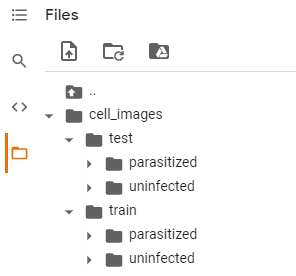

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [5]:
# Storing the path of the extracted "train" folder 
train_dir = '/content/drive/MyDrive/cell_images/train'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [6]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)
    for i, image_name in enumerate(images_path):
    
        try:
            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)
            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))
            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))
            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

# Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
# Storing the path of the extracted "test" folder 
test_dir = '/content/drive/MyDrive/cell_images/test'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [8]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)
    for i, image_name in enumerate(images_path):
        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))
            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

# Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b>Normalize the images

In [9]:
# Try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images/255.).astype('float32')

test_images = (test_images/255.).astype('float32')

As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

###<B>One Hot Encoding on the train and test labels

In [10]:
# Encoding Train Labels
train_labels = to_categorical(train_labels, 2)

# Similarly let us try to encode test labels
test_labels = to_categorical(test_labels, 2)

In [11]:
print(50*'-')
print('one-hot encoding train labels: ', train_labels)
print('one-hot encoding test labels: ', test_labels)
print(50*'-')

--------------------------------------------------
one-hot encoding train labels:  [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
one-hot encoding test labels:  [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
--------------------------------------------------


### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [12]:
# Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LeakyReLU, BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

###<b> Building the model

In [83]:
# Creating sequential model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [84]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks 

In [85]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train our Model

In [86]:
# Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history = model.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 106s 168ms/step - loss: 0.4737 - accuracy: 0.7668 - val_loss: 0.1995 - val_accuracy: 0.9525
Epoch 2/20
624/624 [==============================] - 95s 153ms/step - loss: 0.1334 - accuracy: 0.9503 - val_loss: 0.1655 - val_accuracy: 0.9475
Epoch 3/20
624/624 [==============================] - 98s 157ms/step - loss: 0.1052 - accuracy: 0.9657 - val_loss: 0.1496 - val_accuracy: 0.9545
Epoch 4/20
624/624 [==============================] - 99s 159ms/step - loss: 0.0905 - accuracy: 0.9716 - val_loss: 0.1006 - val_accuracy: 0.9760
Epoch 5/20
624/624 [==============================] - 100s 161ms/step - loss: 0.0781 - accuracy: 0.9745 - val_loss: 0.0764 - val_accuracy: 0.9860
Epoch 6/20
624/624 [==============================] - 101s 161ms/step - loss: 0.0722 - accuracy: 0.9751 - val_loss: 0.0582 - val_accuracy: 0.9866
Epoch 7/20
624/624 [==============================] - 101s 162ms/step - loss: 0.0709 - accuracy: 0.9763 - val_loss: 0.0621 - va

###<b> Evaluating the model on test data

In [87]:
accuracy = model.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 40ms/step - loss: 0.0668 - accuracy: 0.9796

 Test_Accuracy:- 0.9796153903007507


<b> Plotting the confusion matrix

82/82 [==============================] - 3s 40ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



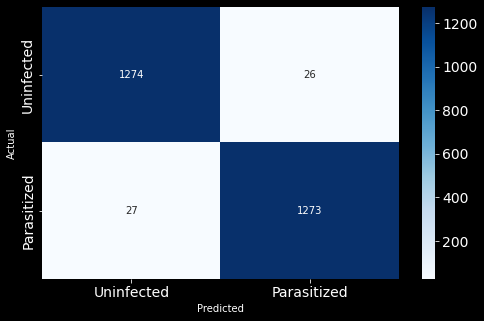

In [88]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Uninfected', 'Parasitized'], cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

<b>Plotting the train and validation curves

In [21]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--', lw=3)
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--', lw=3)
    plt.title("Accuracy vs Epoch", fontsize=18)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.legend(loc="upper left")
    plt.tight_layout()

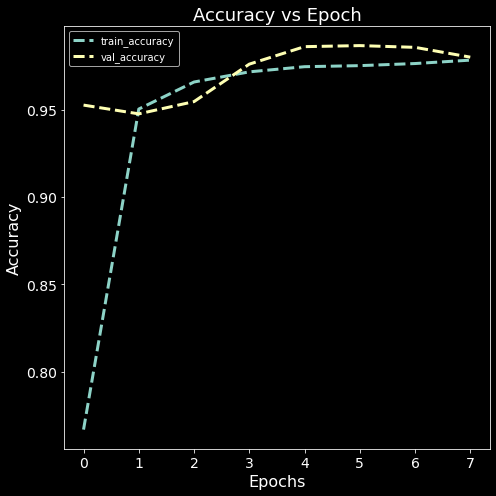

In [90]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [13]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model

In [14]:
# Creating sequential model
model1 = Sequential()

# Build the model here and add new layers
model1.add(Conv2D(filters = 256, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters = 128, kernel_size = 2, padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters = 16, kernel_size = 2, padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(512, activation = "relu"))
model1.add(Dropout(0.1))
model1.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

# Model 1 Summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0

###<b> Compiling the model

In [15]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

<b> Using Callbacks

In [16]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
history1 = model1.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks,  validation_split = 0.2, epochs = 20, verbose = 1)

###<b> Evaluating the model

In [100]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 19s 234ms/step - loss: 0.0635 - accuracy: 0.9823

 Test_Accuracy:- 0.9823076725006104


<b> Plotting the confusion matrix

82/82 [==============================] - 19s 233ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



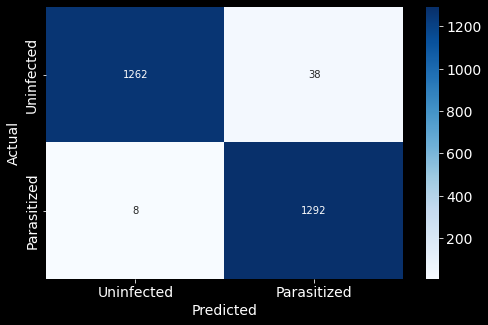

In [101]:
pred = model1.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], 
            yticklabels = ['Uninfected', 'Parasitized'], cmap='Blues')
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)

plt.show()

<b> Plotting the train and the validation curves

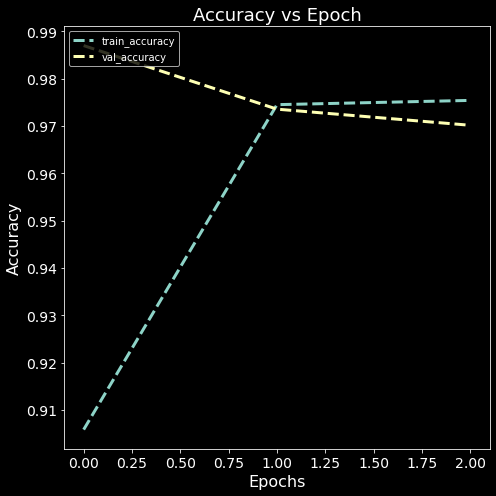

In [102]:
plot_accuracy(history1)

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [23]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model

In [24]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))
model2.add(BatchNormalization())
'''
Complete this model using BatchNormalization layers and by using LeakyRelu as the activation function

'''
model2.add(MaxPooling2D(pool_size = 2))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(512, activation = "relu"))

model2.add(Dropout(0.4))
model2.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 


adam = optimizers.Adam(learning_rate = 0.001)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0

###<b>Compiling the model

In [25]:
model2.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ['accuracy'])

<b> Using callbacks

In [26]:
'''
create the callbacks similarly as done in the base model
As callbacks will help us in saving our checkpoints and stopping at an accuracy where the model doesnot seem to improve
'''
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl2_wts.hdf5', monitor = 'val_loss', save_best_only = True)]


<b>Fit and train the model

In [27]:
history2 = model2.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 166s 265ms/step - loss: 0.3254 - accuracy: 0.8573 - val_loss: 0.1829 - val_accuracy: 0.9930
Epoch 2/20
624/624 [==============================] - 150s 241ms/step - loss: 0.0996 - accuracy: 0.9666 - val_loss: 0.2741 - val_accuracy: 0.9549
Epoch 3/20
624/624 [==============================] - 152s 243ms/step - loss: 0.0817 - accuracy: 0.9721 - val_loss: 0.1050 - val_accuracy: 0.9824
Epoch 4/20
624/624 [==============================] - 156s 250ms/step - loss: 0.0743 - accuracy: 0.9756 - val_loss: 0.1347 - val_accuracy: 0.9782
Epoch 5/20
624/624 [==============================] - 170s 272ms/step - loss: 0.0680 - accuracy: 0.9771 - val_loss: 0.0799 - val_accuracy: 0.9860
Epoch 6/20
624/624 [==============================] - 154s 247ms/step - loss: 0.0677 - accuracy: 0.9778 - val_loss: 0.0785 - val_accuracy: 0.9898
Epoch 7/20
624/624 [==============================] - 152s 243ms/step - loss: 0.0645 - accuracy: 0.9773 - val_loss: 0.1046 -

<b>Plotting the train and validation accuracy

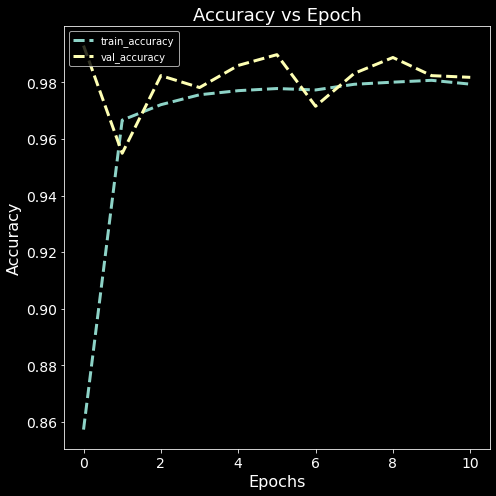

In [28]:
# Plotting the accuracies
plot_accuracy(history2)

###<b>Evaluating the model

In [29]:
# Evaluate the model to calculate the accuracy
accuracy = model2.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 5s 56ms/step - loss: 0.0650 - accuracy: 0.9777

 Test_Accuracy:- 0.9776923060417175


####<b>Observations and insights:
- The inclusion of LeakyReLU doesn't seem to improve validation accuracy compared to previous models. However, the placement of BatchNormalization in the model does appear to have a significant effect in terms of model accuracy. Multiple runs (not shown here) found that BatchNormalization placed in the start of the model improved accuracy from around 96% to nearly 98%. This may have to do with the normalization of the first convolution layer which should regularize the weights and their neuron activation functions. 
- However, the second model (model1) could be incorporated with batchnormalization to see if the 98% accuracy could be improved further. 
- Comparing model1 to model2, yet shows improved confusion for uninfected-parasitized=24 (model2) vs uninfected-parasitized=38 (model1).   

<b> Generate the classification report and confusion matrix 

82/82 [==============================] - 5s 58ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1300
           1       0.98      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



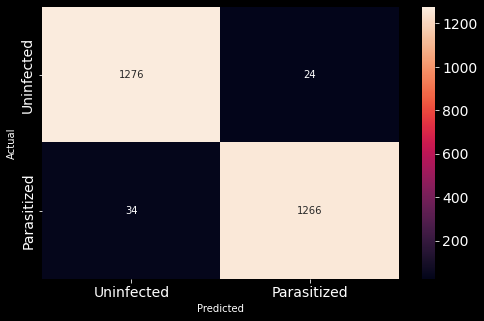

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model2.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)
# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [31]:
backend.clear_session() # Clearing backend for new model

###<b> Using image data generator

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  zoom_range = 0.5, rotation_range = 30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)
# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

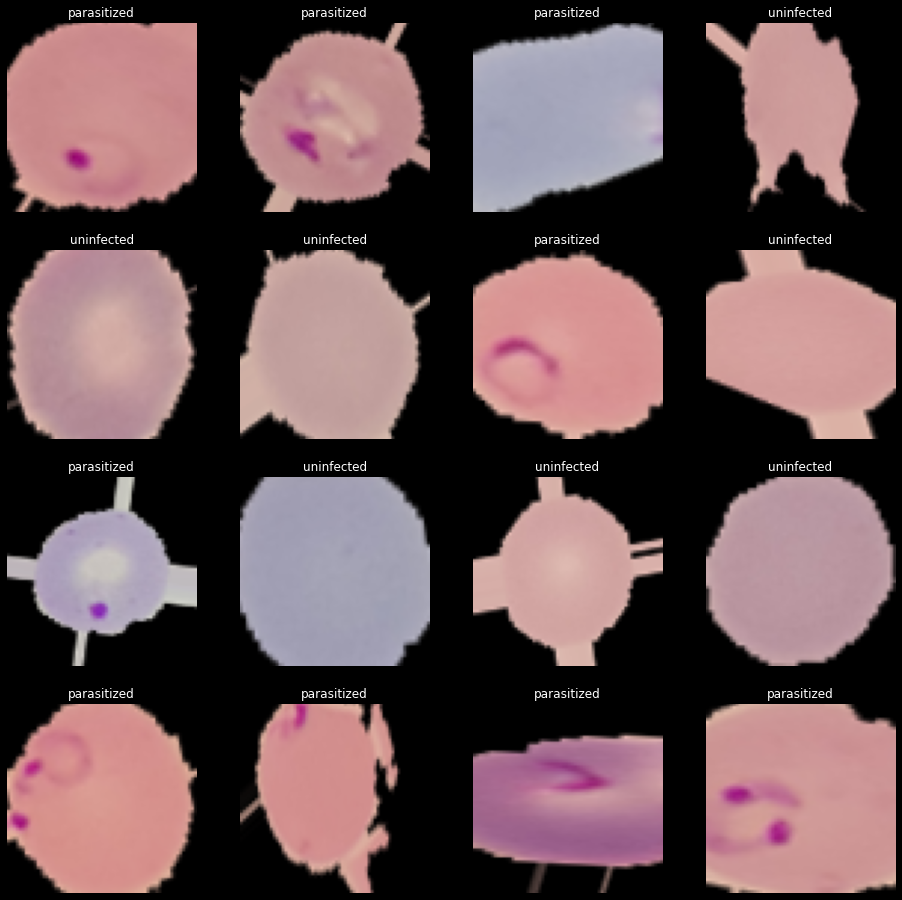

In [33]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

####<b>Observations and insights:
- 

###<b>Building the Model

In [36]:
model3 = Sequential()

# Build the model here
model3.add(Conv2D(64, (3, 3), input_shape = (64, 64, 3), padding = 'same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(512, activation = "relu"))

model3.add(Dropout(0.4))
model3.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model3.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        8224      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)       

<b>Using Callbacks

In [37]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl3_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [38]:
history3 = model3.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32, callbacks = callbacks,
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 315s 1s/step - loss: 0.5046 - accuracy: 0.7567 - val_loss: 0.3957 - val_accuracy: 0.9147
Epoch 2/20
312/312 [==============================] - 341s 1s/step - loss: 0.2217 - accuracy: 0.9157 - val_loss: 0.1102 - val_accuracy: 0.9704
Epoch 3/20
312/312 [==============================] - 256s 818ms/step - loss: 0.1791 - accuracy: 0.9366 - val_loss: 0.0986 - val_accuracy: 0.9679
Epoch 4/20
312/312 [==============================] - 239s 766ms/step - loss: 0.1648 - accuracy: 0.9429 - val_loss: 0.1019 - val_accuracy: 0.9784
Epoch 5/20
312/312 [==============================] - 230s 738ms/step - loss: 0.1578 - accuracy: 0.9473 - val_loss: 0.1004 - val_accuracy: 0.9702


###<B>Evaluating the model

<b>Plot the train and validation accuracy

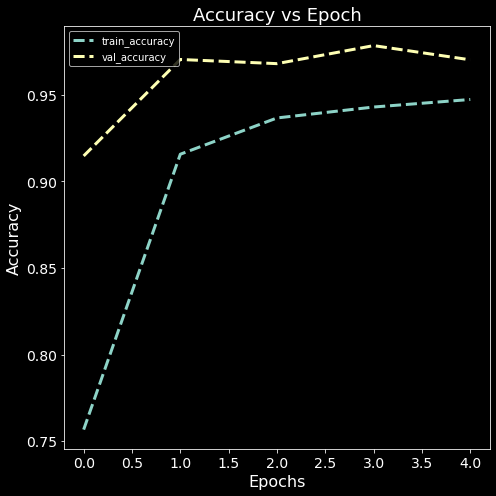

In [39]:
# Potting the accuracies
plot_accuracy(history3)

In [40]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 5s 58ms/step - loss: 0.0974 - accuracy: 0.9750

 Test_Accuracy:- 0.9750000238418579


<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 6s 72ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1300
           1       0.99      0.96      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.98      0.98      0.97      2600
weighted avg       0.98      0.97      0.97      2600



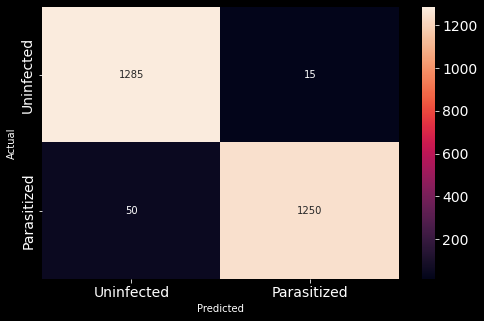

In [41]:
pred = model3.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)
# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [83]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)


In [84]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
from keras.applications.vgg16 import preprocess_input

vgg = VGG16(include_top=False, weights = 'imagenet', input_shape = (64, 64, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [79]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Add classification layers on top of it  
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons
x = BatchNormalization()(x)
pred = Dense(64, activation = 'softmax')(x)

model4 = Model(vgg.input, pred) # Initializing the model

###<b>Compiling the model

In [80]:
# Compiling the model 
adam = optimizers.Adam(learning_rate = 0.001)
model4.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

<b> using callbacks

In [81]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl4_wts.hdf5', monitor = 'val_loss', save_best_only = True)]
  
gen = ImageDataGenerator(
    rotation_range=60, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True, 
    preprocessing_function=preprocess_input
)


<b>Fit and Train the model

In [ ]:
# Fitting the model and running the model for 10 epochs
history4 = model4.fit( .................,........... ,epochs = 10,
            callbacks = callbacks,
            batch_size = 32,
            validation_split = 0.2,
            verbose = 1
)

<b>Plot the train and validation accuracy

In [ ]:
# plotting the accuracies
plot_accuracy(history4)

###**Observations and insights: _____**

*   What can be observed from the validation and train curves?
-Unfortunately, I am unable to construct this model within the window of time I have. Perhaps on resubmission I can complete the final portion and extend it further. 

###<b> Evaluating the model

In [ ]:
# Evaluating the model on test data

<b>Plotting the classification report and confusion matrix

In [ ]:
# Plot the confusion matrix and generate a classification report for the model

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
N/A
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


####<b> Observations and Conclusions drawn from the final model: 
- Model 1 provided the greatest accuracy, >98%. The confusion for uninfected-parasitized was 8, while the uninfected-parasitized was 38. The success of this model can be drawn from the introduction of more convolution layers. While more layers certainly reduced confusion, the performance of the model was challenged with increaed epoch times. Nevertheless, performance improvement can be applied with BatchNormalization and, perhaps, improved accuracy. 



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?
Definitely discerning the parasite as a dark purple feature in the infected RBCs. 
####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?
Each model performed well...but clearly the inclusion of more layers would improve prediction considering model1. Combining the use of BatchNormalization may enhance prediction for model1. 
####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt? I feel uncertain about this since I was unable to obtain a working VGG16 model. Excluding VGG16, the introduction of more layers with BatchNormalization could lead to accuracy. BatchNormalization should help with performance and regularization. Perhaps considering ResNet or some other model would be worth exploring too.  